# PUI 2016 FINAL: Socioeconomic Trends in New York City from 2000 to 2010

In [312]:
#import all necessary modules and packages
import pandas as pd
import json
import os
import pylab as pl
import geopandas as gp
import glob
import zipfile
from sklearn.cluster import KMeans
from matplotlib import cm
from descartes import PolygonPatch
import scipy.cluster as scp
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster as scp
import pandas as pd
from pandas.io.common import ZipFile
import pylab as pl
import fiona
from fiona.crs import from_epsg
import shapely
from geopandas import GeoDataFrame, read_file
from geopandas.tools import sjoin
from shapely.geometry import Point, mapping,shape
import time

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['shape']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [24]:
os.getenv("PUIDATA")

'/home/cusp/wbx200/PUIdata'

In [25]:
#set up a subfolder within Puidata for the final
os.system("mkdir " + os.getenv("PUIDATA") + "/Final")

0

# PART ONE - Obtaining Choropleths of Business Density by Zip Code Area (2000 and 2010)

In [7]:
#1. Find the number of business in 2000 and 2010. Utilized HW11 Solution code and "Business Census Files" hint.

In [33]:
!curl -O "ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp00totals.zip"
os.system("mv " + "zbp00totals.zip " + os.getenv("PUIDATA") + "/Final")
!curl -O "ftp://ftp.census.gov/econ2010/CBP_CSV/zbp10totals.zip"
os.system("mv " + "zbp10totals.zip " + os.getenv("PUIDATA") + "/Final")

^C
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  778k  100  778k    0     0   420k      0  0:00:01  0:00:01 --:--:--  496k


0

In [77]:
df_00 = pd.read_csv(os.getenv("PUIDATA") + "/Final" + "/" + "zbp00totals.zip")

In [78]:
df_00.head()

,ZIP,NAME,EMPFLAG,EMP,QP1,AP,EST
0,501,"HOLTSVILLE, NY",A,0,0,0,1
1,1001,"AGAWAM, MA",NaN,8042,59833,259661,493
2,1002,"AMHERST, MA",NaN,6547,36719,169658,563
3,1003,"AMHERST, MA",NaN,82,308,2482,13
4,1004,"AMHERST, MA",NaN,717,2049,5826,48


In [83]:
df_00.drop(df_00.columns[[1,2,3,4,5]], axis=1, inplace=True)
df_00.head()

,ZIP,EST
0,501,1
1,1001,493
2,1002,563
3,1003,13
4,1004,48


In [106]:
#rename column for future merge
df_00 = df_00.rename(columns={'ZIP': "zipcode"})
df_00 = df_00.rename(columns={'EST': "Est. 2000"})
df_00.head()

,zipcode,Est. 2000
0,501,1
1,1001,493
2,1002,563
3,1003,13
4,1004,48


In [88]:
df_10 = pd.read_csv(os.getenv("PUIDATA") + "/Final" + "/" + "zbp10totals.zip")

In [89]:
df_10.head()

,zip,name,empflag,emp_nf,emp,qp1_nf,qp1,ap_nf,ap,est,city,stabbr,cty_name
0,501,"HOLTSVILLE, NY",A,D,0,D,0,D,0,2,HOLTSVILLE,NY,SUFFOLK
1,1001,"AGAWAM, MA",NaN,G,9185,G,70693,G,314508,448,AGAWAM,MA,HAMPDEN
2,1002,"AMHERST, MA",NaN,G,15633,G,82069,G,351589,570,AMHERST,MA,HAMPSHIRE
3,1003,"AMHERST, MA",NaN,G,168,H,1297,H,5761,16,AMHERST,MA,HAMPSHIRE
4,1004,"AMHERST, MA",NaN,H,189,H,1710,H,7241,21,AMHERST,MA,HAMPSHIRE


In [91]:
df_10.drop(df_10.columns[[1,2,3,4,5,6,7,8,10,11,12]], axis=1, inplace=True)
df_10.head()

,zip,est
0,501,2
1,1001,448
2,1002,570
3,1003,16
4,1004,21


In [108]:
#rename column for future merge
df_10 = df_10.rename(columns={'zip': "zipcode"})
df_10 = df_10.rename(columns={'est': "Est. 2010"})
df_10.head()

,zipcode,Est. 2010
0,501,2
1,1001,448
2,1002,570
3,1003,16
4,1004,21


In [109]:
df_combined = pd.merge(df_00, df_10, on="zipcode", how="outer")
df_combined.head()

,zipcode,Est. 2000,Est. 2010
0,501.0,1.0,2.0
1,1001.0,493.0,448.0
2,1002.0,563.0,570.0
3,1003.0,13.0,16.0
4,1004.0,48.0,21.0


In [372]:
df_combined_1 = df_combined
df_combined_1['Difference in Biz'] = df_combined_1['Est. 2010'] - df_combined_1['Est. 2000']
df_combined_1.head()

,zipcode,Est. 2000,Est. 2010,Difference in Biz
0,501.0,1.0,2.0,1.0
1,1001.0,493.0,448.0,-45.0
2,1002.0,563.0,570.0,7.0
3,1003.0,13.0,16.0,3.0
4,1004.0,48.0,21.0,-27.0


# TABLE 1. Businesses (Est. in 2000 and 2010) and Differential by Zip Code.

In [4]:
#2. Gather a zip code shapefile and merge it with the number of businesses.  Utilized HW11 Solution code.

In [51]:
!curl -O "https://raw.githubusercontent.com/fedhere/PUI2016_fb55/master/HW11_fb55/nyc-zip-code-tabulation-areas-polygons.geojson"
os.system("mv " + "nyc-zip-code-tabulation-areas-polygons.geojson " + os.getenv("PUIDATA") + "/Final")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  591k  100  591k    0     0  1563k      0 --:--:-- --:--:-- --:--:-- 3998k


0

In [167]:
nyczipshape = gp.read_file(os.getenv("PUIDATA") + "/Final" + "/" + "nyc-zip-code-tabulation-areas-polygons.geojson")
print ("ZIPCODES:", len(np.unique(nyczipshape.postalCode)), 
       "POLYGONS:", len(nyczipshape.postalCode),
       "the difference is due to island with same zip as parts of land,", 
       "but disjoint shapes")
nyczips = nyczipshape.postalCode.values.astype(int)
print ("number of NYC zip codes:", len(nyczips))

ZIPCODES: 247 POLYGONS: 262 the difference is due to island with same zip as parts of land, but disjoint shapes
number of NYC zip codes: 262


In [168]:
#checking types for merging
print ("zipcode column type", type(nyczips[0]))

zipcode column type <class 'numpy.int64'>


In [169]:
nyczipshape.head()

,@id,BLDGpostalCode,CTY_FIPS,OBJECTID,PO_NAME,STATE,ST_FIPS,Shape_Area,Shape_Leng,borough,geometry,postalCode
0,http://nyc.pediacities.com/Resource/PostalCode...,0,081,1,Jackson Heights,NY,36,2.016328e+07,20624.692317,Queens,POLYGON ((-73.86942457284175 40.74915687096787...,11372
1,http://nyc.pediacities.com/Resource/PostalCode...,0,081,2,Glen Oaks,NY,36,2.260653e+07,23002.816039,Queens,POLYGON ((-73.71068374074007 40.75004039450917...,11004
2,http://nyc.pediacities.com/Resource/PostalCode...,0,081,3,New Hyde Park,NY,36,6.269333e+06,15749.161511,Queens,POLYGON ((-73.70098278625547 40.73889569923034...,11040
3,http://nyc.pediacities.com/Resource/PostalCode...,0,081,4,Bellerose,NY,36,4.941836e+07,35932.810639,Queens,POLYGON ((-73.72270447144122 40.75373371438336...,11426
4,http://nyc.pediacities.com/Resource/PostalCode...,0,081,5,Fresh Meadows,NY,36,6.938587e+07,38693.565676,Queens,POLYGON ((-73.81088634744755 40.72717187575918...,11365


In [170]:
# rename postalcode column name to zipcode and remove columns deemed unnecessary
nyczipshape = nyczipshape.rename(columns={'postalCode': "zipcode"})
nyczipshape.zipcode = pd.to_numeric(nyczipshape.zipcode)
nyczipshape = nyczipshape[['zipcode', 'borough', 'Shape_Area', 'geometry', 'PO_NAME']]
nyczipshape.head()

,zipcode,borough,Shape_Area,geometry,PO_NAME
0,11372,Queens,2.016328e+07,POLYGON ((-73.86942457284175 40.74915687096787...,Jackson Heights
1,11004,Queens,2.260653e+07,POLYGON ((-73.71068374074007 40.75004039450917...,Glen Oaks
2,11040,Queens,6.269333e+06,POLYGON ((-73.70098278625547 40.73889569923034...,New Hyde Park
3,11426,Queens,4.941836e+07,POLYGON ((-73.72270447144122 40.75373371438336...,Bellerose
4,11365,Queens,6.938587e+07,POLYGON ((-73.81088634744755 40.72717187575918...,Fresh Meadows


In [171]:
#merge business establishment data with zip code shape file
zipbiz_merge = pd.merge(df_combined, nyczipshape, on="zipcode")
zipbiz_merge.head()

,zipcode,Est. 2000,Est. 2010,borough,Shape_Area,geometry,PO_NAME
0,10001.0,7317.0,7241.0,Manhattan,1.779494e+07,POLYGON ((-74.00827017711134 40.75258714368449...,New York
1,10002.0,2277.0,2872.0,Manhattan,2.628013e+07,POLYGON ((-73.97441674489379 40.73642441865476...,New York
2,10003.0,3683.0,4113.0,Manhattan,1.553838e+07,POLYGON ((-73.97986374196766 40.73497446573838...,New York
3,10004.0,1294.0,1398.0,Manhattan,4.001782e+06,"POLYGON ((-74.00596661578348 40.7043243225291,...",New York
4,10004.0,1294.0,1398.0,Manhattan,1.202708e+06,POLYGON ((-74.04166368343016 40.69644987183209...,New York


In [6]:
#3. Find the density of businesses and showing them on a choropleth. Utilized "PUI Final" hints.

In [172]:
zipbiz_merge['Area (mi^2)'] = zipbiz_merge['Shape_Area'] / (2.788*10**7)
zipbiz_merge['2000 Business Density'] = zipbiz_merge['Est. 2000'] / zipbiz_merge['Area (mi^2)']
zipbiz_merge['2010 Business Density'] = zipbiz_merge['Est. 2010'] / zipbiz_merge['Area (mi^2)']
zipbiz_merge.head()

,zipcode,Est. 2000,Est. 2010,borough,Shape_Area,geometry,PO_NAME,Area (mi^2),2000 Business Density,2010 Business Density
0,10001.0,7317.0,7241.0,Manhattan,1.779494e+07,POLYGON ((-74.00827017711134 40.75258714368449...,New York,0.638269,11463.817868,11344.745823
1,10002.0,2277.0,2872.0,Manhattan,2.628013e+07,POLYGON ((-73.97441674489379 40.73642441865476...,New York,0.942616,2415.618317,3046.840495
2,10003.0,3683.0,4113.0,Manhattan,1.553838e+07,POLYGON ((-73.97986374196766 40.73497446573838...,New York,0.557331,6608.286361,7379.821288
3,10004.0,1294.0,1398.0,Manhattan,4.001782e+06,"POLYGON ((-74.00596661578348 40.7043243225291,...",New York,0.143536,9015.163328,9739.720504
4,10004.0,1294.0,1398.0,Manhattan,1.202708e+06,POLYGON ((-74.04166368343016 40.69644987183209...,New York,0.043139,29996.249111,32407.075933


In [173]:
zipbiz_merge = GeoDataFrame(zipbiz_merge)

In [293]:
type(zipbiz_merge)

geopandas.geodataframe.GeoDataFrame

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/geodataframe.py:447: UserWarning: Unrecognized scheme "unrecognized". Using "Quantiles" instead
  return plot_dataframe(self, *args, **kwargs)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/geodataframe.py:447: UserWarning: Invalid k: 29 (2 <= k <= 9), setting k=5 (default)
  return plot_dataframe(self, *args, **kwargs)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3142: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


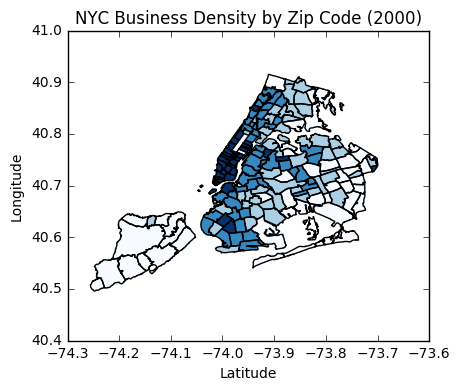

In [346]:
zipbiz_merge.plot(column='2000 Business Density', scheme = 'unrecognized', k=29, colormap = 'Blues', alpha = 1)
plt.title("NYC Business Density by Zip Code (2000)")
plt.xlabel('Latitude')
plt.ylabel('Longitude')

# Figure 1. NYC Business Density by Zip Code (2000). This plot shows the business density by zip code, normalized by each zip code's area.  From the plot, we can see that the densest areas are lower Manhattan and parts of downtown Brooklyn.  We will now compare this to the 2010 plot.

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/geodataframe.py:447: UserWarning: Unrecognized scheme "unrecognized". Using "Quantiles" instead
  return plot_dataframe(self, *args, **kwargs)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/geodataframe.py:447: UserWarning: Invalid k: 29 (2 <= k <= 9), setting k=5 (default)
  return plot_dataframe(self, *args, **kwargs)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3142: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


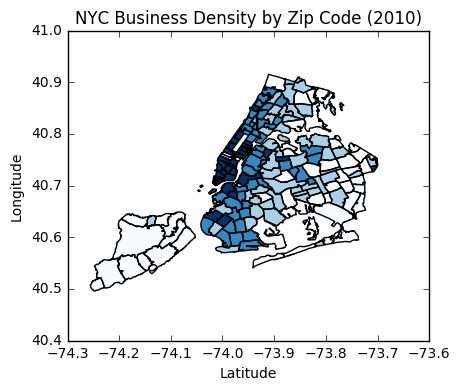

In [347]:
zipbiz_merge.plot(column='2010 Business Density', scheme = 'unrecognized', k=29, colormap = 'Blues', alpha = 1)
plt.title("NYC Business Density by Zip Code (2010)")
plt.xlabel('Latitude')
plt.ylabel('Longitude')

# Figure 2. NYC Business Density by Zip Code (2010). This plot shows the business density by zip code, normalized by each zip code's area.  By eye, it is difficult to discern any differences from the 2000 data, except an increase in the Williamsburg and Greenpoint area.

In [368]:
zipbiz_merge_1 = zipbiz_merge

In [370]:
zipbiz_merge_1['Biz Dens Diff'] = zipbiz_merge_1['2010 Business Density'] - zipbiz_merge_1['2000 Business Density']
zipbiz_merge_1.head()

,zipcode,Est. 2000,Est. 2010,borough,Shape_Area,geometry,PO_NAME,Area (mi^2),2000 Business Density,2010 Business Density,Biz Dens Diff
0,10001.0,7317.0,7241.0,Manhattan,1.779494e+07,POLYGON ((-74.00827017711134 40.75258714368449...,New York,0.638269,11463.817868,11344.745823,-119.072046
1,10002.0,2277.0,2872.0,Manhattan,2.628013e+07,POLYGON ((-73.97441674489379 40.73642441865476...,New York,0.942616,2415.618317,3046.840495,631.222178
2,10003.0,3683.0,4113.0,Manhattan,1.553838e+07,POLYGON ((-73.97986374196766 40.73497446573838...,New York,0.557331,6608.286361,7379.821288,771.534927
3,10004.0,1294.0,1398.0,Manhattan,4.001782e+06,"POLYGON ((-74.00596661578348 40.7043243225291,...",New York,0.143536,9015.163328,9739.720504,724.557176
4,10004.0,1294.0,1398.0,Manhattan,1.202708e+06,POLYGON ((-74.04166368343016 40.69644987183209...,New York,0.043139,29996.249111,32407.075933,2410.826822


/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/geodataframe.py:447: UserWarning: Unrecognized scheme "unrecognized". Using "Quantiles" instead
  return plot_dataframe(self, *args, **kwargs)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/geodataframe.py:447: UserWarning: Invalid k: 29 (2 <= k <= 9), setting k=5 (default)
  return plot_dataframe(self, *args, **kwargs)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3142: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


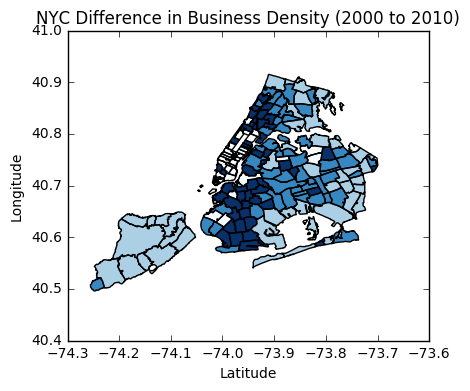

In [371]:
zipbiz_merge_1.plot(column='Biz Dens Diff', scheme = 'unrecognized', k=29, colormap = 'Blues', alpha = 1)
plt.title("NYC Difference in Business Density (2000 to 2010)")
plt.xlabel('Latitude')
plt.ylabel('Longitude')

# Figure 3.  NYC Difference in Business Density by Zip Code (2000 to 2010). This plot shows the difference in business density by zip code from 2000 to 2010.  This confirms our observation that there was an increase in businesses in some Brooklyn neighborhoods.

# PART TWO - Collecting Census Data

In [142]:
#took the Census data shortcut.
!curl -O "http://cosmo.nyu.edu/~fb55/PUI2016/data/census00_final.json"
os.system("mv " + "census00_final.json " + os.getenv("PUIDATA") + "/Final")
!curl -O "http://cosmo.nyu.edu/~fb55/PUI2016/data/census10_final.json"
os.system("mv " + "census10_final.json " + os.getenv("PUIDATA") + "/Final")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  381k  100  381k    0     0  33.5M      0 --:--:-- --:--:-- --:--:-- 46.5M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  383k  100  383k    0     0  36.2M      0 --:--:-- --:--:-- --:--:-- 53.4M


0

In [244]:
census_00 = pd.read_json(os.getenv("PUIDATA") + "/Final" + "/" + "census00_final.json")
census_00.head()

,age,diversity,geo_id,income,population
0,0.0,NaN,1400000US36047054300,NaN,0
1,0.0,NaN,1400000US36081121100,NaN,0
10,47.5,34.0,1400000US36029001401,18125.0,106
100,39.3,89.2,1400000US36001001901,52093.0,2656
1000,40.9,98.7,1400000US36029013800,55842.0,7663


In [246]:
census_00.age = pd.to_numeric(census_00.age)
census_00.diversity = pd.to_numeric(census_00.diversity)
census_00.income = pd.to_numeric(census_00.income)
census_00.population = pd.to_numeric(census_00.population)

census_00 = census_00.rename(columns={'age': "Age (2000)"})
census_00 = census_00.rename(columns={'diversity': "Diversity % (2000)"})
census_00 = census_00.rename(columns={'income': "Income (2000)"})
census_00 = census_00.rename(columns={'population': "Population (2000)"})
census_00.head()

,Age (2000),Diversity % (2000),geo_id,Income (2000),Population (2000)
0,0.0,NaN,1400000US36047054300,NaN,0
1,0.0,NaN,1400000US36081121100,NaN,0
10,47.5,34.0,1400000US36029001401,18125.0,106
100,39.3,89.2,1400000US36001001901,52093.0,2656
1000,40.9,98.7,1400000US36029013800,55842.0,7663


In [248]:
census_10 = pd.read_json(os.getenv("PUIDATA") + "/Final" + "/" + "census10_final.json")
census_10.head()

,age,diversity,geo_id,income,population
0,0.0,NaN,1400000US36081038301,NaN,0
1,38.0,50.0,1400000US36005002400,NaN,4
10,16.4,98.7,1400000US36047053700,30938.0,3575
100,33.5,82.4,1400000US36001013300,40513.0,4427
1000,44.5,97.4,1400000US36029014803,58455.0,6028


In [249]:
census_10.age = pd.to_numeric(census_10.age)
census_10.diversity = pd.to_numeric(census_10.diversity)
census_10.income = pd.to_numeric(census_10.income)
census_10.population = pd.to_numeric(census_10.population)

census_10 = census_10.rename(columns={'age': "Age (2010)"})
census_10 = census_10.rename(columns={'diversity': "Diversity % (2010)"})
census_10 = census_10.rename(columns={'income': "Income (2010)"})
census_10 = census_10.rename(columns={'population': "Population (2010)"})
census_10.head()

,Age (2010),Diversity % (2010),geo_id,Income (2010),Population (2010)
0,0.0,NaN,1400000US36081038301,NaN,0
1,38.0,50.0,1400000US36005002400,NaN,4
10,16.4,98.7,1400000US36047053700,30938.0,3575
100,33.5,82.4,1400000US36001013300,40513.0,4427
1000,44.5,97.4,1400000US36029014803,58455.0,6028


In [250]:
census_merge = pd.merge(census_00, census_10, on="geo_id", how="outer")
census_merge.head()

,Age (2000),Diversity % (2000),geo_id,Income (2000),Population (2000),Age (2010),Diversity % (2010),Income (2010),Population (2010)
0,0.0,NaN,1400000US36047054300,NaN,0.0,33.8,70.9,31591.0,327.0
1,0.0,NaN,1400000US36081121100,NaN,0.0,0.0,NaN,NaN,0.0
2,47.5,34.0,1400000US36029001401,18125.0,106.0,NaN,NaN,NaN,NaN
3,39.3,89.2,1400000US36001001901,52093.0,2656.0,38.0,85.8,59344.0,2607.0
4,40.9,98.7,1400000US36029013800,55842.0,7663.0,45.8,98.1,67292.0,7818.0


In [251]:
census_merge['Age Delta'] = census_merge['Age (2010)'] - census_merge['Age (2000)']
census_merge['Diversity Delta'] = census_merge['Diversity % (2010)'] - census_merge['Diversity % (2000)']
census_merge['Income Delta'] = census_merge['Income (2010)'] - census_merge['Income (2000)']
census_merge['Population Delta'] = census_merge['Population (2010)'] - census_merge['Population (2000)']
census_merge.head()

,Age (2000),Diversity % (2000),geo_id,Income (2000),Population (2000),Age (2010),Diversity % (2010),Income (2010),Population (2010),Age Delta,Diversity Delta,Income Delta,Population Delta
0,0.0,NaN,1400000US36047054300,NaN,0.0,33.8,70.9,31591.0,327.0,33.8,NaN,NaN,327.0
1,0.0,NaN,1400000US36081121100,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0
2,47.5,34.0,1400000US36029001401,18125.0,106.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,39.3,89.2,1400000US36001001901,52093.0,2656.0,38.0,85.8,59344.0,2607.0,-1.3,-3.4,7251.0,-49.0
4,40.9,98.7,1400000US36029013800,55842.0,7663.0,45.8,98.1,67292.0,7818.0,4.9,-0.6,11450.0,155.0


In [252]:
census_merge['GEOID'] = census_merge.geo_id.str[9:]
census_merge.head()

,Age (2000),Diversity % (2000),geo_id,Income (2000),Population (2000),Age (2010),Diversity % (2010),Income (2010),Population (2010),Age Delta,Diversity Delta,Income Delta,Population Delta,GEOID
0,0.0,NaN,1400000US36047054300,NaN,0.0,33.8,70.9,31591.0,327.0,33.8,NaN,NaN,327.0,36047054300
1,0.0,NaN,1400000US36081121100,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,36081121100
2,47.5,34.0,1400000US36029001401,18125.0,106.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36029001401
3,39.3,89.2,1400000US36001001901,52093.0,2656.0,38.0,85.8,59344.0,2607.0,-1.3,-3.4,7251.0,-49.0,36001001901
4,40.9,98.7,1400000US36029013800,55842.0,7663.0,45.8,98.1,67292.0,7818.0,4.9,-0.6,11450.0,155.0,36029013800


# PART THREE - Obtaining Choropleths of Census Data by Census Tract (2000 and 2010) and Clustering

In [189]:
#utilized Census Tract file directly from the U.S. Census website
!curl -O "ftp://ftp2.census.gov/geo/tiger/TIGER2016/TRACT/tl_2016_36_tract.zip"
os.system("mv " + "tl_2016_36_tract.zip " + os.getenv("PUIDATA") + "/Final")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7368k  100 7368k    0     0   482k      0  0:00:15  0:00:15 --:--:--  492k


256

In [193]:
os.system("unzip " + os.getenv("PUIDATA") + "/Final" + "/" + "tl_2016_36_tract.zip")

256

In [349]:
nycctshape = gp.read_file(os.getenv("PUIDATA") + "/Final" + "/" + "tl_2016_36_tract.shp")
nycctshape = GeoDataFrame(nycctshape)
nycctshape.head()

,ALAND,AWATER,COUNTYFP,FUNCSTAT,GEOID,INTPTLAT,INTPTLON,MTFCC,NAME,NAMELSAD,STATEFP,TRACTCE,geometry
0,183329987,3232878,093,S,36093033102,+42.7779982,-074.1727018,G5020,331.02,Census Tract 331.02,36,033102,"POLYGON ((-74.30655 42.750642, -74.30624499999..."
1,854904,0,093,S,36093020102,+42.8295375,-073.9161408,G5020,201.02,Census Tract 201.02,36,020102,"POLYGON ((-73.92513099999999 42.82029, -73.924..."
2,66000589,1265253,093,S,36093032504,+42.9010522,-074.0288926,G5020,325.04,Census Tract 325.04,36,032504,"POLYGON ((-74.09298 42.955868, -74.08805199999..."
3,213987,0,081,S,36081003400,+40.6847731,-073.8581871,G5020,34,Census Tract 34,36,003400,"POLYGON ((-73.86629499999999 40.683189, -73.86..."
4,146970,0,081,S,36081003900,+40.7627994,-073.9409316,G5020,39,Census Tract 39,36,003900,"POLYGON ((-73.943304 40.760658, -73.942472 40...."


In [350]:
nycctshape = nycctshape.loc[nycctshape['COUNTYFP'].isin(['005','061','085','047','081'])]
nycctshape.head()

,ALAND,AWATER,COUNTYFP,FUNCSTAT,GEOID,INTPTLAT,INTPTLON,MTFCC,NAME,NAMELSAD,STATEFP,TRACTCE,geometry
3,213987,0,081,S,36081003400,+40.6847731,-073.8581871,G5020,34,Census Tract 34,36,003400,"POLYGON ((-73.86629499999999 40.683189, -73.86..."
4,146970,0,081,S,36081003900,+40.7627994,-073.9409316,G5020,39,Census Tract 39,36,003900,"POLYGON ((-73.943304 40.760658, -73.942472 40...."
5,180006,0,081,S,36081003600,+40.6837714,-073.8568176,G5020,36,Census Tract 36,36,003600,"POLYGON ((-73.86410099999999 40.682373, -73.86..."
6,386629,14591,081,S,36081003700,+40.7624148,-073.9434494,G5020,37,Census Tract 37,36,003700,"POLYGON ((-73.950766 40.755313, -73.9507349999..."
7,176214,0,081,S,36081003800,+40.6847999,-073.8474941,G5020,38,Census Tract 38,36,003800,"POLYGON ((-73.852801 40.684253, -73.8519549999..."


In [351]:
censusct_merge = pd.merge(census_merge, nycctshape, on='GEOID')
censusct_merge.head()

,Age (2000),Diversity % (2000),geo_id,Income (2000),Population (2000),Age (2010),Diversity % (2010),Income (2010),Population (2010),Age Delta,...,COUNTYFP,FUNCSTAT,INTPTLAT,INTPTLON,MTFCC,NAME,NAMELSAD,STATEFP,TRACTCE,geometry
0,0.0,NaN,1400000US36047054300,NaN,0.0,33.8,70.9,31591.0,327.0,33.8,...,047,S,+40.7014969,-073.9716023,G5020,543,Census Tract 543,36,054300,"POLYGON ((-73.980649 40.701561, -73.9804549999..."
1,0.0,NaN,1400000US36081121100,NaN,0.0,0.0,NaN,NaN,0.0,0.0,...,081,S,+40.7456558,-073.8083171,G5020,1211,Census Tract 1211,36,121100,"POLYGON ((-73.813785 40.744555, -73.81374 40.7..."
2,37.5,75.3,1400000US36047000100,63333.0,5260.0,43.7,78.3,85396.0,4338.0,6.2,...,047,S,+40.7002150,-073.9938088,G5020,1,Census Tract 1,36,000100,"POLYGON ((-73.9975 40.699653, -73.996697999999..."
3,25.3,33.5,1400000US36047000200,29219.0,1303.0,25.8,36.1,54688.0,1470.0,0.5,...,047,S,+40.6532475,-074.0110678,G5020,2,Census Tract 2,36,000200,"POLYGON ((-74.014596 40.651333, -74.0140119999..."
4,38.7,84.1,1400000US36047000301,83739.0,5036.0,40.7,85.9,160833.0,4259.0,2.0,...,047,S,+40.6963724,-073.9973734,G5020,3.01,Census Tract 3.01,36,000301,"POLYGON ((-74.000277 40.694959, -73.999882 40...."


In [352]:
censusct_merge = GeoDataFrame(censusct_merge)

In [353]:
type(censusct_merge)

geopandas.geodataframe.GeoDataFrame

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/geodataframe.py:447: UserWarning: Unrecognized scheme "unrecognized". Using "Quantiles" instead
  return plot_dataframe(self, *args, **kwargs)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/geodataframe.py:447: UserWarning: Invalid k: 29 (2 <= k <= 9), setting k=5 (default)
  return plot_dataframe(self, *args, **kwargs)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3142: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


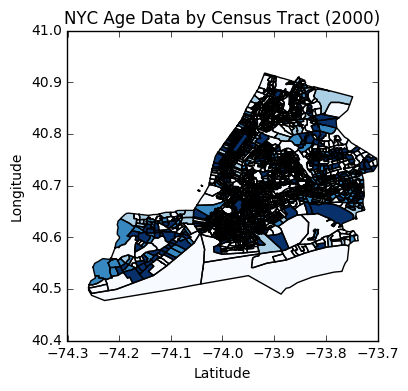

In [354]:
censusct_merge.plot(column='Age (2000)', scheme = 'unrecognized', k=29, colormap = 'Blues', alpha = 1)
plt.title("NYC Age Data by Census Tract (2000)")
plt.xlabel('Latitude')
plt.ylabel('Longitude')

# Figure 4. Average Age by NYC Census Tract (2000).  This plot shows average age by NYC census tract in 2000.  The darker the color, the older the average age.  We see that the outskirts of the city seem to be younger.

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/geodataframe.py:447: UserWarning: Unrecognized scheme "unrecognized". Using "Quantiles" instead
  return plot_dataframe(self, *args, **kwargs)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/geodataframe.py:447: UserWarning: Invalid k: 29 (2 <= k <= 9), setting k=5 (default)
  return plot_dataframe(self, *args, **kwargs)


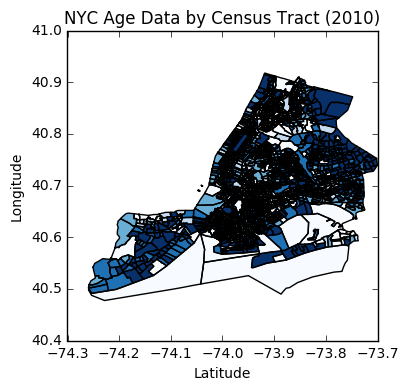

In [355]:
censusct_merge.plot(column='Age (2010)', scheme = 'unrecognized', k=29, colormap = 'Blues', alpha = 1)
plt.title("NYC Age Data by Census Tract (2010)")
plt.xlabel('Latitude')
plt.ylabel('Longitude')

#  Figure 5. Average Age by NYC Census Tract (2010).  This plot shows average age by NYC census tract in 2000.  The darker the color, the older the average age.  We see that the outskirts of the city seem to be younger.  At first glance, there is no discernible difference between 2000 and 2010.

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/geodataframe.py:447: UserWarning: Unrecognized scheme "unrecognized". Using "Quantiles" instead
  return plot_dataframe(self, *args, **kwargs)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/geodataframe.py:447: UserWarning: Invalid k: 29 (2 <= k <= 9), setting k=5 (default)
  return plot_dataframe(self, *args, **kwargs)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3142: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


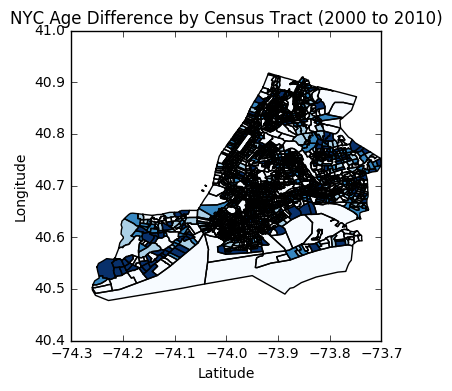

In [356]:
censusct_merge.plot(column='Age Delta', scheme = 'unrecognized', k=29, colormap = 'Blues', alpha = 1)
plt.title("NYC Age Difference by Census Tract (2000 to 2010)")
plt.xlabel('Latitude')
plt.ylabel('Longitude')

#  Figure 6. Average Age Difference by NYC Census Tract (2000 to 2010). This plot shows average age difference from 2010 to 2000 by census tract. 

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/geodataframe.py:447: UserWarning: Unrecognized scheme "unrecognized". Using "Quantiles" instead
  return plot_dataframe(self, *args, **kwargs)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/geodataframe.py:447: UserWarning: Invalid k: 29 (2 <= k <= 9), setting k=5 (default)
  return plot_dataframe(self, *args, **kwargs)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3142: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


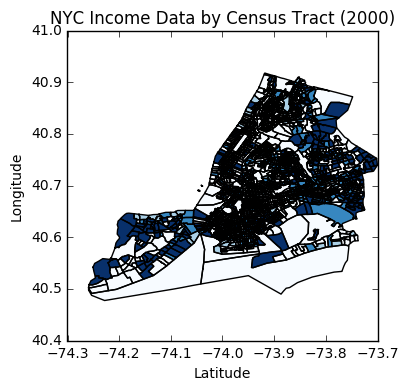

In [357]:
censusct_merge.plot(column='Income (2000)', scheme = 'unrecognized', k=29, colormap = 'Blues', alpha = 1)
plt.title("NYC Income Data by Census Tract (2000)")
plt.xlabel('Latitude')
plt.ylabel('Longitude')

# Figure 7. Average Income by NYC Census Tract (2000).  This plot shows average income broken down by NYC Census tract.

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/geodataframe.py:447: UserWarning: Unrecognized scheme "unrecognized". Using "Quantiles" instead
  return plot_dataframe(self, *args, **kwargs)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/geodataframe.py:447: UserWarning: Invalid k: 29 (2 <= k <= 9), setting k=5 (default)
  return plot_dataframe(self, *args, **kwargs)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3142: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


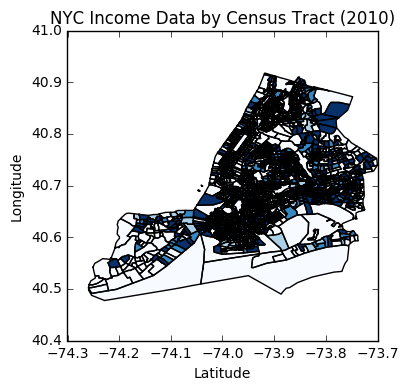

In [358]:
censusct_merge.plot(column='Income (2010)', scheme = 'unrecognized', k=29, colormap = 'Blues', alpha = 1)
plt.title("NYC Income Data by Census Tract (2010)")
plt.xlabel('Latitude')
plt.ylabel('Longitude')

# Figure 8. Average Income by NYC Census Tract (2010).  This plot shows average income broken down by NYC Census tract.

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/geodataframe.py:447: UserWarning: Unrecognized scheme "unrecognized". Using "Quantiles" instead
  return plot_dataframe(self, *args, **kwargs)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/geodataframe.py:447: UserWarning: Invalid k: 29 (2 <= k <= 9), setting k=5 (default)
  return plot_dataframe(self, *args, **kwargs)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3142: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


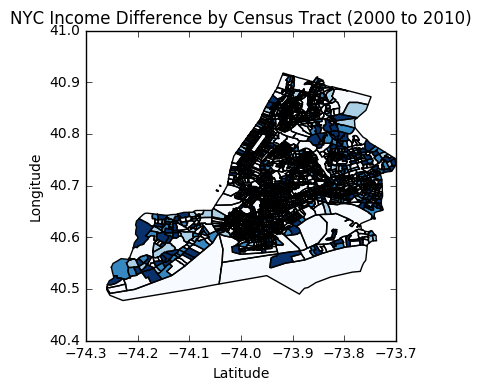

In [378]:
censusct_merge.plot(column='Income Delta', scheme = 'unrecognized', k=29, colormap = 'Blues', alpha = 1)
plt.title("NYC Income Difference by Census Tract (2000 to 2010)")
plt.xlabel('Latitude')
plt.ylabel('Longitude')

# Figure 9. Average Income Difference by NYC Census Tract (2000 to 2010).  This plot shows the difference in average income between 2010 and 2000 by census tract.

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/geodataframe.py:447: UserWarning: Unrecognized scheme "unrecognized". Using "Quantiles" instead
  return plot_dataframe(self, *args, **kwargs)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/geodataframe.py:447: UserWarning: Invalid k: 29 (2 <= k <= 9), setting k=5 (default)
  return plot_dataframe(self, *args, **kwargs)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3142: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


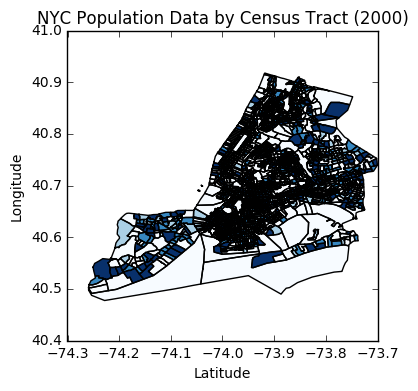

In [363]:
censusct_merge.plot(column='Population (2000)', scheme = 'unrecognized', k=29, colormap = 'Blues', alpha = 1)
plt.title("NYC Population Data by Census Tract (2000)")
plt.xlabel('Latitude')
plt.ylabel('Longitude')

# Figure 10. Average Population by NYC Census Tract (2000).  This plot shows average population by NYC census tract in 2000.

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/geodataframe.py:447: UserWarning: Unrecognized scheme "unrecognized". Using "Quantiles" instead
  return plot_dataframe(self, *args, **kwargs)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/geodataframe.py:447: UserWarning: Invalid k: 29 (2 <= k <= 9), setting k=5 (default)
  return plot_dataframe(self, *args, **kwargs)


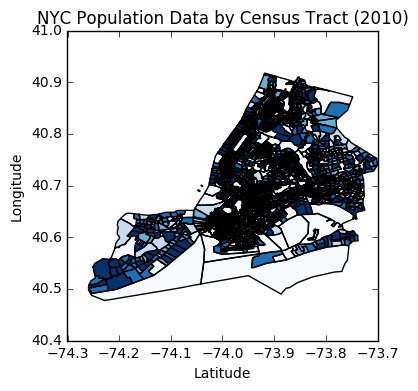

In [361]:
censusct_merge.plot(column='Population (2010)', scheme = 'unrecognized', k=29, colormap = 'Blues', alpha = 1)
plt.title("NYC Population Data by Census Tract (2010)")
plt.xlabel('Latitude')
plt.ylabel('Longitude')

# Figure 11. Average Population by NYC Census Tract (2010).  This plot shows average population by NYC census tract.

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/geodataframe.py:447: UserWarning: Unrecognized scheme "unrecognized". Using "Quantiles" instead
  return plot_dataframe(self, *args, **kwargs)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/geodataframe.py:447: UserWarning: Invalid k: 29 (2 <= k <= 9), setting k=5 (default)
  return plot_dataframe(self, *args, **kwargs)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3142: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


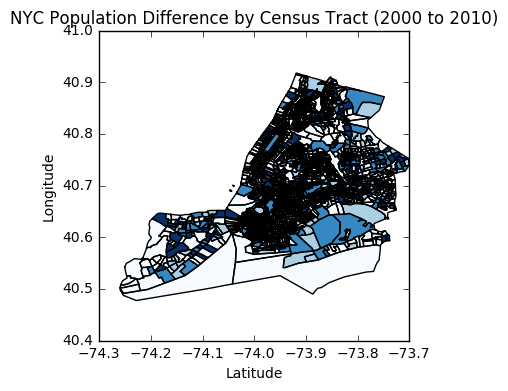

In [360]:
censusct_merge.plot(column='Population Delta', scheme = 'unrecognized', k=29, colormap = 'Blues', alpha = 1)
plt.title("NYC Population Difference by Census Tract (2000 to 2010)")
plt.xlabel('Latitude')
plt.ylabel('Longitude')

# Figure 12. Average Population Difference by NYC Census Tract (2000 to 2010).  This plot shows the difference in average population between 2010 and 2000 by census tract.

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/geodataframe.py:447: UserWarning: Unrecognized scheme "unrecognized". Using "Quantiles" instead
  return plot_dataframe(self, *args, **kwargs)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/geodataframe.py:447: UserWarning: Invalid k: 29 (2 <= k <= 9), setting k=5 (default)
  return plot_dataframe(self, *args, **kwargs)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3142: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


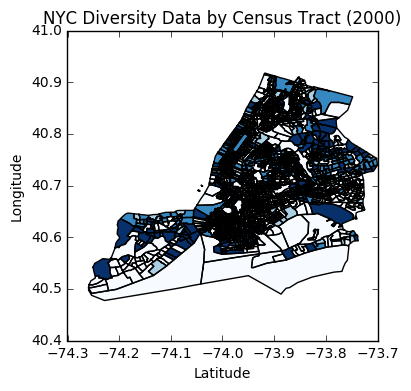

In [364]:
censusct_merge.plot(column='Diversity % (2000)', scheme = 'unrecognized', k=29, colormap = 'Blues', alpha = 1)
plt.title("NYC Diversity Data by Census Tract (2000)")
plt.xlabel('Latitude')
plt.ylabel('Longitude')

# Figure 13. Average Diversity by NYC Census Tract (2000).  This plot shows average diversity (measured by % white) by census tract.

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/geodataframe.py:447: UserWarning: Unrecognized scheme "unrecognized". Using "Quantiles" instead
  return plot_dataframe(self, *args, **kwargs)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/geodataframe.py:447: UserWarning: Invalid k: 29 (2 <= k <= 9), setting k=5 (default)
  return plot_dataframe(self, *args, **kwargs)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3142: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


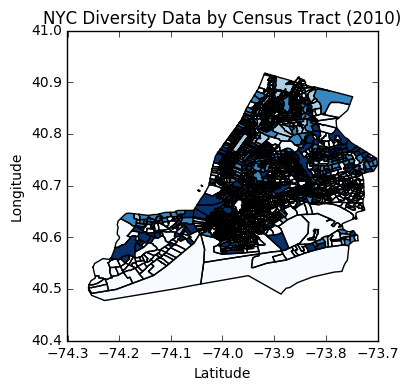

In [366]:
censusct_merge.plot(column='Diversity % (2010)', scheme = 'unrecognized', k=29, colormap = 'Blues', alpha = 1)
plt.title("NYC Diversity Data by Census Tract (2010)")
plt.xlabel('Latitude')
plt.ylabel('Longitude')

# Figure 14. Average Diversity by NYC Census Tract (2010).  This plot shows average diversity (measured by % white) by census tract.

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/geodataframe.py:447: UserWarning: Unrecognized scheme "unrecognized". Using "Quantiles" instead
  return plot_dataframe(self, *args, **kwargs)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/geodataframe.py:447: UserWarning: Invalid k: 29 (2 <= k <= 9), setting k=5 (default)
  return plot_dataframe(self, *args, **kwargs)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3142: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


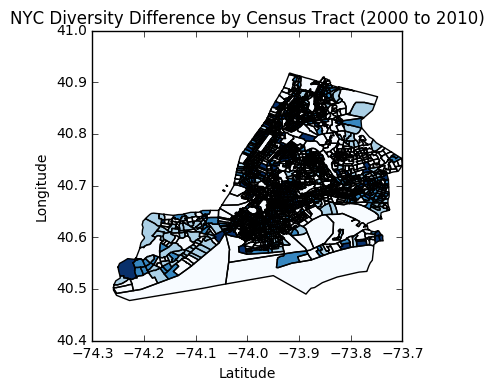

In [367]:
censusct_merge.plot(column='Diversity Delta', scheme = 'unrecognized', k=29, colormap = 'Blues', alpha = 1)
plt.title("NYC Diversity Difference by Census Tract (2000 to 2010)")
plt.xlabel('Latitude')
plt.ylabel('Longitude')

# Figure 15. Average Diversity Difference by NYC Census Tract (2000 to 2010).  This plot shows average diversity (measured by % white) difference by census tract from 2010 to 2000.

# PART FOUR - Obtaining Choropleths of Census Data by Zip Code (2000 and 2010) and Clustering

In [317]:
censusct_merge = censusct_merge.to_crs(epsg=4326)
censusct_merge.head()

,Age (2000),Diversity % (2000),geo_id,Income (2000),Population (2000),Age (2010),Diversity % (2010),Income (2010),Population (2010),Age Delta,...,FUNCSTAT,INTPTLAT,INTPTLON,MTFCC,NAME,NAMELSAD,STATEFP,TRACTCE,geometry,Centroid
0,0.0,NaN,1400000US36047054300,NaN,0.0,33.8,70.9,31591.0,327.0,33.8,...,S,+40.7014969,-073.9716023,G5020,543,Census Tract 543,36,054300,POINT (-73.9718940815203 40.70189567250441),POINT (-73.9718940815203 40.70189567250441)
1,0.0,NaN,1400000US36081121100,NaN,0.0,0.0,NaN,NaN,0.0,0.0,...,S,+40.7456558,-073.8083171,G5020,1211,Census Tract 1211,36,121100,POINT (-73.80485510952509 40.7453236925332),POINT (-73.80485510952509 40.7453236925332)
2,37.5,75.3,1400000US36047000100,63333.0,5260.0,43.7,78.3,85396.0,4338.0,6.2,...,S,+40.7002150,-073.9938088,G5020,1,Census Tract 1,36,000100,POINT (-73.99380885498341 40.70021502015082),POINT (-73.99380885498341 40.70021502015082)
3,25.3,33.5,1400000US36047000200,29219.0,1303.0,25.8,36.1,54688.0,1470.0,0.5,...,S,+40.6532475,-074.0110678,G5020,2,Census Tract 2,36,000200,POINT (-74.0110677763363 40.65324754788919),POINT (-74.0110677763363 40.65324754788919)
4,38.7,84.1,1400000US36047000301,83739.0,5036.0,40.7,85.9,160833.0,4259.0,2.0,...,S,+40.6963724,-073.9973734,G5020,3.01,Census Tract 3.01,36,000301,POINT (-73.99737339275738 40.69637238395354),POINT (-73.99737339275738 40.69637238395354)


In [318]:
zipbiz_merge.crs = from_epsg(4326)
#zipbiz_merge.to_crs(epsg=4326)
zipbiz_merge.head()

,zipcode,Est. 2000,Est. 2010,borough,Shape_Area,geometry,PO_NAME,Area (mi^2),2000 Business Density,2010 Business Density
0,10001.0,7317.0,7241.0,Manhattan,1.779494e+07,POLYGON ((-74.00827017711134 40.75258714368449...,New York,0.638269,11463.817868,11344.745823
1,10002.0,2277.0,2872.0,Manhattan,2.628013e+07,POLYGON ((-73.97441674489379 40.73642441865476...,New York,0.942616,2415.618317,3046.840495
2,10003.0,3683.0,4113.0,Manhattan,1.553838e+07,POLYGON ((-73.97986374196766 40.73497446573838...,New York,0.557331,6608.286361,7379.821288
3,10004.0,1294.0,1398.0,Manhattan,4.001782e+06,"POLYGON ((-74.00596661578348 40.7043243225291,...",New York,0.143536,9015.163328,9739.720504
4,10004.0,1294.0,1398.0,Manhattan,1.202708e+06,POLYGON ((-74.04166368343016 40.69644987183209...,New York,0.043139,29996.249111,32407.075933


In [311]:
censusct_merge['geometry'] = censusct_merge.geometry.centroid
censusct_merge.head()

,Age (2000),Diversity % (2000),geo_id,Income (2000),Population (2000),Age (2010),Diversity % (2010),Income (2010),Population (2010),Age Delta,...,FUNCSTAT,INTPTLAT,INTPTLON,MTFCC,NAME,NAMELSAD,STATEFP,TRACTCE,geometry,Centroid
0,0.0,NaN,1400000US36047054300,NaN,0.0,33.8,70.9,31591.0,327.0,33.8,...,S,+40.7014969,-073.9716023,G5020,543,Census Tract 543,36,054300,POINT (-73.9718940815203 40.70189567250441),POINT (-73.9718940815203 40.70189567250441)
1,0.0,NaN,1400000US36081121100,NaN,0.0,0.0,NaN,NaN,0.0,0.0,...,S,+40.7456558,-073.8083171,G5020,1211,Census Tract 1211,36,121100,POINT (-73.80485510952509 40.7453236925332),POINT (-73.80485510952509 40.7453236925332)
2,37.5,75.3,1400000US36047000100,63333.0,5260.0,43.7,78.3,85396.0,4338.0,6.2,...,S,+40.7002150,-073.9938088,G5020,1,Census Tract 1,36,000100,POINT (-73.99380885498341 40.70021502015082),POINT (-73.99380885498341 40.70021502015082)
3,25.3,33.5,1400000US36047000200,29219.0,1303.0,25.8,36.1,54688.0,1470.0,0.5,...,S,+40.6532475,-074.0110678,G5020,2,Census Tract 2,36,000200,POINT (-74.0110677763363 40.65324754788919),POINT (-74.0110677763363 40.65324754788919)
4,38.7,84.1,1400000US36047000301,83739.0,5036.0,40.7,85.9,160833.0,4259.0,2.0,...,S,+40.6963724,-073.9973734,G5020,3.01,Census Tract 3.01,36,000301,POINT (-73.99737339275738 40.69637238395354),POINT (-73.99737339275738 40.69637238395354)


In [329]:
merged=sjoin(censusct_merge, zipbiz_merge, how='left')
merged.columns
merged.head()

,Age (2000),Diversity % (2000),geo_id,Income (2000),Population (2000),Age (2010),Diversity % (2010),Income (2010),Population (2010),Age Delta,...,index_right,zipcode,Est. 2000,Est. 2010,borough,Shape_Area,PO_NAME,Area (mi^2),2000 Business Density,2010 Business Density
0,0.0,NaN,1400000US36047054300,NaN,0.0,33.8,70.9,31591.0,327.0,33.8,...,193.0,11251.0,2.0,3.0,Brooklyn,1.037932e+07,Brooklyn,0.372286,5.372220,8.058330
1,0.0,NaN,1400000US36081121100,NaN,0.0,0.0,NaN,NaN,0.0,0.0,...,205.0,11365.0,553.0,643.0,Queens,6.938587e+07,Fresh Meadows,2.488733,222.201451,258.364436
2,37.5,75.3,1400000US36047000100,63333.0,5260.0,43.7,78.3,85396.0,4338.0,6.2,...,155.0,11201.0,2131.0,2567.0,Brooklyn,4.109489e+07,Brooklyn,1.473992,1445.734111,1741.529547
3,25.3,33.5,1400000US36047000200,29219.0,1303.0,25.8,36.1,54688.0,1470.0,0.5,...,185.0,11232.0,1006.0,1174.0,Brooklyn,5.587907e+07,Brooklyn,2.004271,501.928225,585.749241
4,38.7,84.1,1400000US36047000301,83739.0,5036.0,40.7,85.9,160833.0,4259.0,2.0,...,155.0,11201.0,2131.0,2567.0,Brooklyn,4.109489e+07,Brooklyn,1.473992,1445.734111,1741.529547


In [330]:
merged.columns

Index(['Age (2000)', 'Diversity % (2000)', 'geo_id', 'Income (2000)',
       'Population (2000)', 'Age (2010)', 'Diversity % (2010)',
       'Income (2010)', 'Population (2010)', 'Age Delta', 'Diversity Delta',
       'Income Delta', 'Population Delta', 'GEOID', 'ALAND', 'AWATER',
       'COUNTYFP', 'FUNCSTAT', 'INTPTLAT', 'INTPTLON', 'MTFCC', 'NAME',
       'NAMELSAD', 'STATEFP', 'TRACTCE', 'geometry', 'Centroid', 'index_right',
       'zipcode', 'Est. 2000', 'Est. 2010', 'borough', 'Shape_Area', 'PO_NAME',
       'Area (mi^2)', '2000 Business Density', '2010 Business Density'],
      dtype='object')

In [375]:
merged_agg = merged.groupby(['zipcode'], as_index=False).agg({'Age (2000)':"mean", 'Age (2010)':"mean", 'Age Delta':"mean",
                                 'Diversity % (2000)':"mean", 'Diversity % (2010)':"mean", 'Diversity Delta':"mean",
                                 'Income (2000)':"mean", 'Income (2010)':"mean", 'Income Delta':"mean",
                                 'Population (2000)':"mean", 'Population (2010)':"mean", 'Population Delta':"mean",
                                    }) 
merged_agg.head()

,zipcode,Population (2010),Diversity % (2010),Age (2000),Diversity Delta,Income (2000),Age Delta,Population Delta,Diversity % (2000),Age (2010),Population (2000),Income Delta,Income (2010)
0,10001.0,2743.000000,61.440000,37.10,-3.320000,52482.400000,-2.660000,394.800000,64.760000,34.440000,2348.200000,21125.800000,73608.20
1,10002.0,5849.083333,36.008333,37.00,5.541667,24335.916667,2.416667,-412.083333,30.466667,39.416667,6261.166667,14713.333333,39049.25
2,10003.0,5528.200000,76.630000,33.97,-1.350000,67424.400000,-1.300000,233.900000,77.980000,32.670000,5294.300000,28177.000000,95601.40
3,10004.0,0.000000,NaN,26.50,NaN,NaN,-26.500000,-2.000000,100.000000,0.000000,2.000000,NaN,NaN
4,10006.0,4479.000000,68.900000,31.70,-6.100000,81609.000000,-2.100000,2954.000000,75.000000,29.600000,1525.000000,29611.000000,111220.00


In [377]:
agg_zip_merge = pd.merge(merged_agg, zipbiz_merge, on="zipcode")
agg_zip_merge.head()

,zipcode,Population (2010),Diversity % (2010),Age (2000),Diversity Delta,Income (2000),Age Delta,Population Delta,Diversity % (2000),Age (2010),...,Est. 2000,Est. 2010,borough,Shape_Area,geometry,PO_NAME,Area (mi^2),2000 Business Density,2010 Business Density,Biz Dens Diff
0,10001.0,2743.000000,61.440000,37.10,-3.320000,52482.400000,-2.660000,394.800000,64.760000,34.440000,...,7317.0,7241.0,Manhattan,1.779494e+07,POLYGON ((-74.00827017711134 40.75258714368449...,New York,0.638269,11463.817868,11344.745823,-119.072046
1,10002.0,5849.083333,36.008333,37.00,5.541667,24335.916667,2.416667,-412.083333,30.466667,39.416667,...,2277.0,2872.0,Manhattan,2.628013e+07,POLYGON ((-73.97441674489379 40.73642441865476...,New York,0.942616,2415.618317,3046.840495,631.222178
2,10003.0,5528.200000,76.630000,33.97,-1.350000,67424.400000,-1.300000,233.900000,77.980000,32.670000,...,3683.0,4113.0,Manhattan,1.553838e+07,POLYGON ((-73.97986374196766 40.73497446573838...,New York,0.557331,6608.286361,7379.821288,771.534927
3,10004.0,0.000000,NaN,26.50,NaN,NaN,-26.500000,-2.000000,100.000000,0.000000,...,1294.0,1398.0,Manhattan,4.001782e+06,"POLYGON ((-74.00596661578348 40.7043243225291,...",New York,0.143536,9015.163328,9739.720504,724.557176
4,10004.0,0.000000,NaN,26.50,NaN,NaN,-26.500000,-2.000000,100.000000,0.000000,...,1294.0,1398.0,Manhattan,1.202708e+06,POLYGON ((-74.04166368343016 40.69644987183209...,New York,0.043139,29996.249111,32407.075933,2410.826822


In [379]:
agg_zip_merge = GeoDataFrame(agg_zip_merge)
type(agg_zip_merge)

geopandas.geodataframe.GeoDataFrame

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/geodataframe.py:447: UserWarning: Unrecognized scheme "unrecognized". Using "Quantiles" instead
  return plot_dataframe(self, *args, **kwargs)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/geodataframe.py:447: UserWarning: Invalid k: 29 (2 <= k <= 9), setting k=5 (default)
  return plot_dataframe(self, *args, **kwargs)


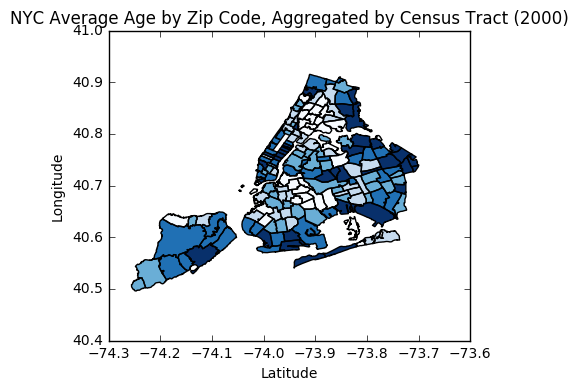

In [381]:
agg_zip_merge.plot(column='Age (2000)', scheme = 'unrecognized', k=29, colormap = 'Blues', alpha = 1)
plt.title("NYC Average Age by Zip Code, Aggregated by Census Tract (2000)")
plt.xlabel('Latitude')
plt.ylabel('Longitude')

# Figure 16. Average Age By Zip Code, Aggregated by Census Tract (2000).  This plot shows average age by zip code, aggregated by census tract.

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/geodataframe.py:447: UserWarning: Unrecognized scheme "unrecognized". Using "Quantiles" instead
  return plot_dataframe(self, *args, **kwargs)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/geodataframe.py:447: UserWarning: Invalid k: 29 (2 <= k <= 9), setting k=5 (default)
  return plot_dataframe(self, *args, **kwargs)


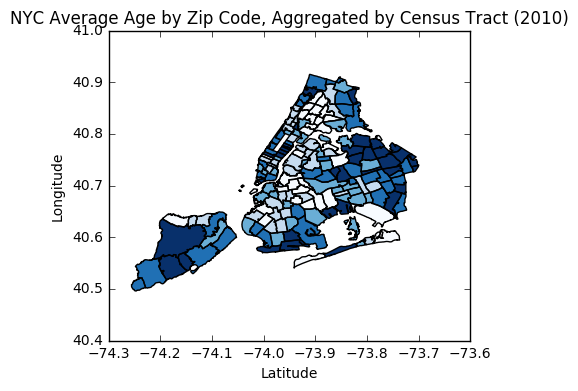

In [382]:
agg_zip_merge.plot(column='Age (2010)', scheme = 'unrecognized', k=29, colormap = 'Blues', alpha = 1)
plt.title("NYC Average Age by Zip Code, Aggregated by Census Tract (2010)")
plt.xlabel('Latitude')
plt.ylabel('Longitude')

# Figure 17. Average Age By Zip Code, Aggregated by Census Tract (2010).  This plot shows average age by zip code, aggregated by census tract.

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/geodataframe.py:447: UserWarning: Unrecognized scheme "unrecognized". Using "Quantiles" instead
  return plot_dataframe(self, *args, **kwargs)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/geodataframe.py:447: UserWarning: Invalid k: 29 (2 <= k <= 9), setting k=5 (default)
  return plot_dataframe(self, *args, **kwargs)


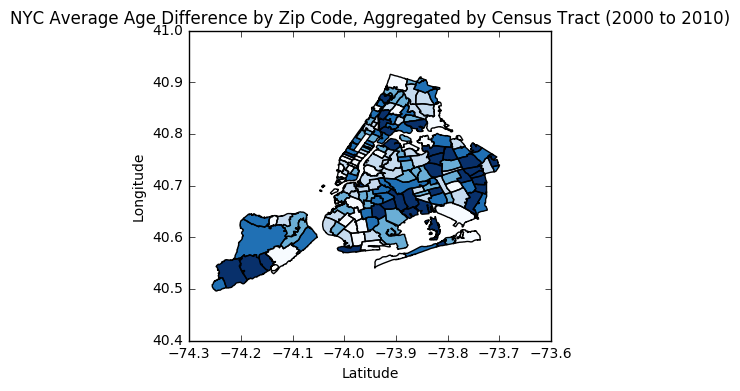

In [383]:
agg_zip_merge.plot(column='Age Delta', scheme = 'unrecognized', k=29, colormap = 'Blues', alpha = 1)
plt.title("NYC Average Age Difference by Zip Code, Aggregated by Census Tract (2000 to 2010)")
plt.xlabel('Latitude')
plt.ylabel('Longitude')

# Figure 18. Average Age Difference By Zip Code, Aggregated by Census Tract (2000-2010).  This plot shows average age difference by zip code, aggregated by census tract from 2010 to 2000.

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/geodataframe.py:447: UserWarning: Unrecognized scheme "unrecognized". Using "Quantiles" instead
  return plot_dataframe(self, *args, **kwargs)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/geodataframe.py:447: UserWarning: Invalid k: 29 (2 <= k <= 9), setting k=5 (default)
  return plot_dataframe(self, *args, **kwargs)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3142: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


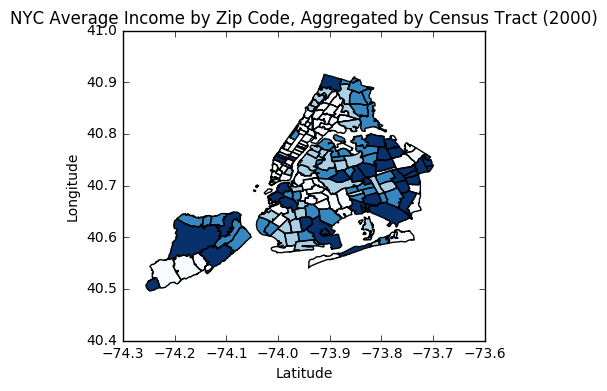

In [384]:
agg_zip_merge.plot(column='Income (2000)', scheme = 'unrecognized', k=29, colormap = 'Blues', alpha = 1)
plt.title("NYC Average Income by Zip Code, Aggregated by Census Tract (2000)")
plt.xlabel('Latitude')
plt.ylabel('Longitude')

# Figure 19. Average Income By Zip Code, Aggregated by Census Tract (2000). This plot shows average income by zip code, aggregated by census tract.

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/geodataframe.py:447: UserWarning: Unrecognized scheme "unrecognized". Using "Quantiles" instead
  return plot_dataframe(self, *args, **kwargs)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/geodataframe.py:447: UserWarning: Invalid k: 29 (2 <= k <= 9), setting k=5 (default)
  return plot_dataframe(self, *args, **kwargs)


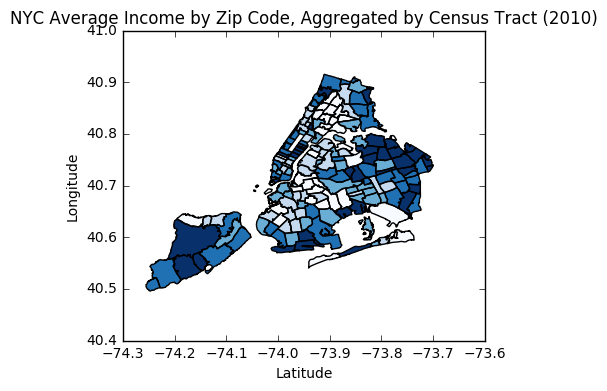

In [385]:
agg_zip_merge.plot(column='Age (2010)', scheme = 'unrecognized', k=29, colormap = 'Blues', alpha = 1)
plt.title("NYC Average Income by Zip Code, Aggregated by Census Tract (2010)")
plt.xlabel('Latitude')
plt.ylabel('Longitude')

# Figure 20. Average Income By Zip Code, Aggregated by Census Tract (2010).  This plot shows average income by zip code, aggregated by census tract.

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/geodataframe.py:447: UserWarning: Unrecognized scheme "unrecognized". Using "Quantiles" instead
  return plot_dataframe(self, *args, **kwargs)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/geodataframe.py:447: UserWarning: Invalid k: 29 (2 <= k <= 9), setting k=5 (default)
  return plot_dataframe(self, *args, **kwargs)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3142: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


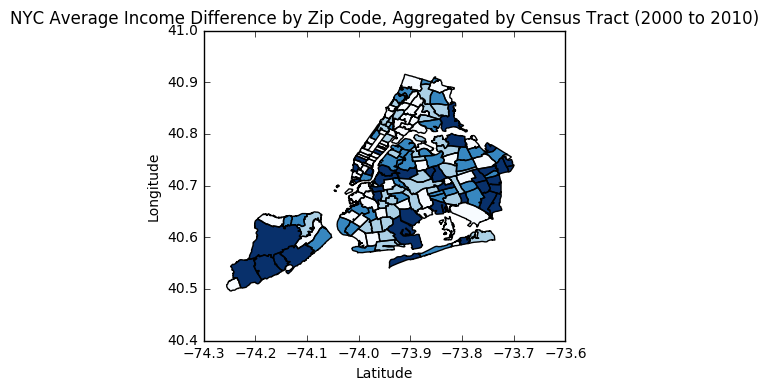

In [386]:
agg_zip_merge.plot(column='Income Delta', scheme = 'unrecognized', k=29, colormap = 'Blues', alpha = 1)
plt.title("NYC Average Income Difference by Zip Code, Aggregated by Census Tract (2000 to 2010)")
plt.xlabel('Latitude')
plt.ylabel('Longitude')

# Figure 21. Average Income Difference By Zip Code, Aggregated by Census Tract (2000-2010).  This plot shows average income difference by zip code, aggregated by census tract, from 2010 to 2000.

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/geodataframe.py:447: UserWarning: Unrecognized scheme "unrecognized". Using "Quantiles" instead
  return plot_dataframe(self, *args, **kwargs)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/geodataframe.py:447: UserWarning: Invalid k: 29 (2 <= k <= 9), setting k=5 (default)
  return plot_dataframe(self, *args, **kwargs)


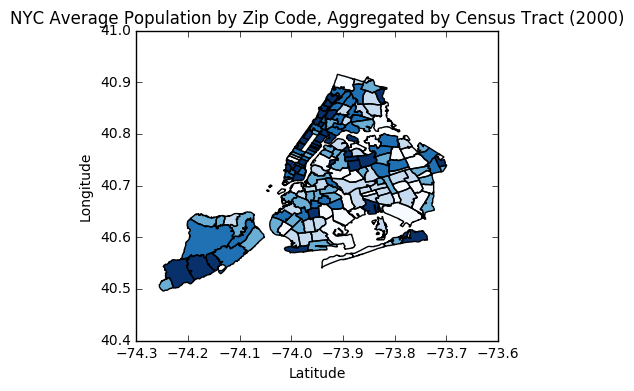

In [387]:
agg_zip_merge.plot(column='Population (2000)', scheme = 'unrecognized', k=29, colormap = 'Blues', alpha = 1)
plt.title("NYC Average Population by Zip Code, Aggregated by Census Tract (2000)")
plt.xlabel('Latitude')
plt.ylabel('Longitude')

# Figure 22. Average Population By Zip Code, Aggregated by Census Tract (2000).  This plot shows average population by zip code, aggregated by census tract.

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/geodataframe.py:447: UserWarning: Unrecognized scheme "unrecognized". Using "Quantiles" instead
  return plot_dataframe(self, *args, **kwargs)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/geodataframe.py:447: UserWarning: Invalid k: 29 (2 <= k <= 9), setting k=5 (default)
  return plot_dataframe(self, *args, **kwargs)


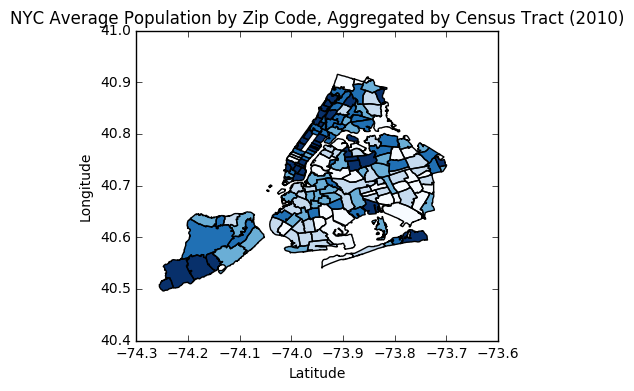

In [388]:
agg_zip_merge.plot(column='Population (2010)', scheme = 'unrecognized', k=29, colormap = 'Blues', alpha = 1)
plt.title("NYC Average Population by Zip Code, Aggregated by Census Tract (2010)")
plt.xlabel('Latitude')
plt.ylabel('Longitude')

# Figure 23. Average Population By Zip Code, Aggregated by Census Tract (2010). This plot shows population income by zip code, aggregated by census tract.

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/geodataframe.py:447: UserWarning: Unrecognized scheme "unrecognized". Using "Quantiles" instead
  return plot_dataframe(self, *args, **kwargs)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/geodataframe.py:447: UserWarning: Invalid k: 29 (2 <= k <= 9), setting k=5 (default)
  return plot_dataframe(self, *args, **kwargs)


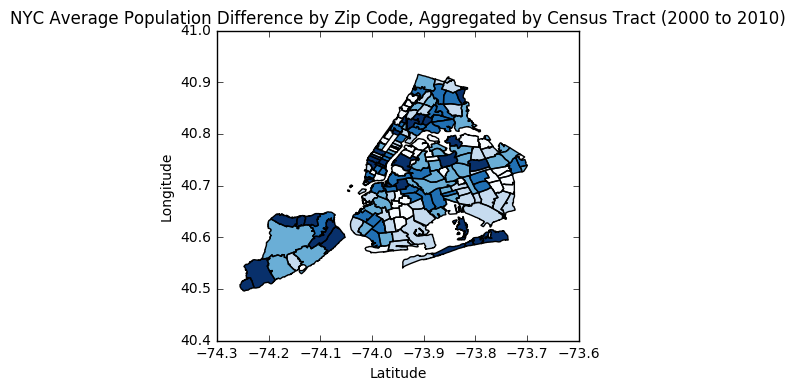

In [389]:
agg_zip_merge.plot(column='Population Delta', scheme = 'unrecognized', k=29, colormap = 'Blues', alpha = 1)
plt.title("NYC Average Population Difference by Zip Code, Aggregated by Census Tract (2000 to 2010)")
plt.xlabel('Latitude')
plt.ylabel('Longitude')

# Figure 24. Average Population Difference By Zip Code, Aggregated by Census Tract (2000-2010).  This plot shows average population difference by zip code, aggregated by census tract, from 2010 to 2000.

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/geodataframe.py:447: UserWarning: Unrecognized scheme "unrecognized". Using "Quantiles" instead
  return plot_dataframe(self, *args, **kwargs)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/geodataframe.py:447: UserWarning: Invalid k: 29 (2 <= k <= 9), setting k=5 (default)
  return plot_dataframe(self, *args, **kwargs)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3142: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


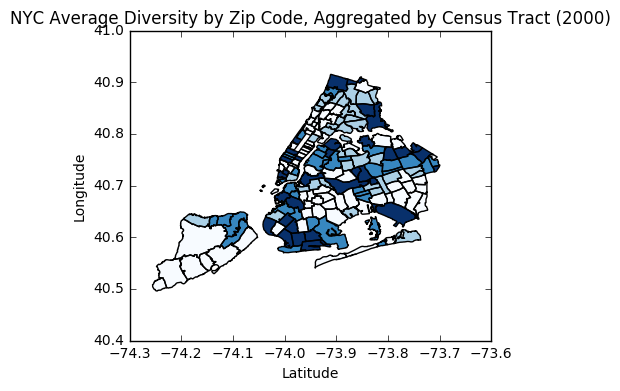

In [391]:
agg_zip_merge.plot(column='Diversity % (2000)', scheme = 'unrecognized', k=29, colormap = 'Blues', alpha = 1)
plt.title("NYC Average Diversity by Zip Code, Aggregated by Census Tract (2000)")
plt.xlabel('Latitude')
plt.ylabel('Longitude')

# Figure 25. Average Diversity By Zip Code, Aggregated by Census Tract (2000).  This plot shows average diversity (% white) by zip code, aggregated by census tract.

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/geodataframe.py:447: UserWarning: Unrecognized scheme "unrecognized". Using "Quantiles" instead
  return plot_dataframe(self, *args, **kwargs)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/geodataframe.py:447: UserWarning: Invalid k: 29 (2 <= k <= 9), setting k=5 (default)
  return plot_dataframe(self, *args, **kwargs)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3142: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


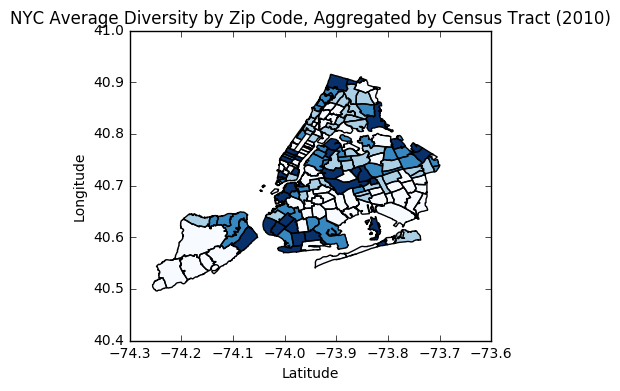

In [392]:
agg_zip_merge.plot(column='Diversity % (2010)', scheme = 'unrecognized', k=29, colormap = 'Blues', alpha = 1)
plt.title("NYC Average Diversity by Zip Code, Aggregated by Census Tract (2010)")
plt.xlabel('Latitude')
plt.ylabel('Longitude')

# Figure 26. Average Diversity By Zip Code, Aggregated by Census Tract (2010). This plot shows average diversity (% white) by zip code, aggregated by census tract.

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/geodataframe.py:447: UserWarning: Unrecognized scheme "unrecognized". Using "Quantiles" instead
  return plot_dataframe(self, *args, **kwargs)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/geodataframe.py:447: UserWarning: Invalid k: 29 (2 <= k <= 9), setting k=5 (default)
  return plot_dataframe(self, *args, **kwargs)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3142: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


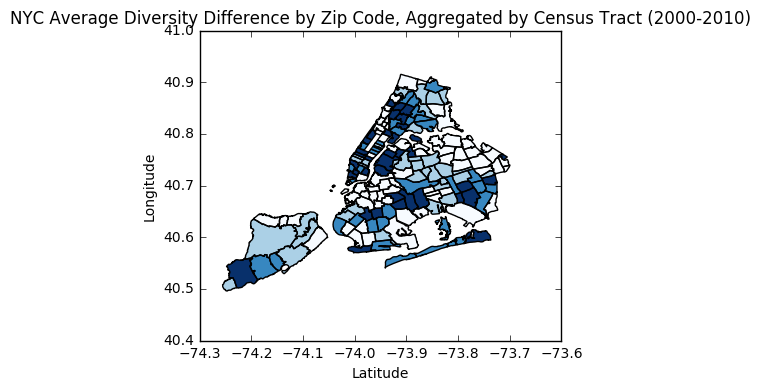

In [393]:
agg_zip_merge.plot(column='Diversity Delta', scheme = 'unrecognized', k=29, colormap = 'Blues', alpha = 1)
plt.title("NYC Average Diversity Difference by Zip Code, Aggregated by Census Tract (2000-2010)")
plt.xlabel('Latitude')
plt.ylabel('Longitude')

# Figure 27 Average Diversity Difference By Zip Code, Aggregated by Census Tract (2000-2010).  This plot shows average diversity (% white) difference by zip code, aggregated by census tract, from 2010 to 2000.

In [396]:
n = 5
kmeans = KMeans(random_state=234, n_clusters=n)
results = km.fit(agg_zip_merge[ [ u'Age (2000)'], u'Income (2000)', u'Population (2000)', u'Diversity % (2000)']
agg_zip_merge['kmeans'] = results.labels
results.head()

SyntaxError: invalid syntax (<ipython-input-396-c7d5977195b2>, line 4)

In [397]:
n = 5
kmeans = KMeans(random_state=234, n_clusters=n)
results = km.fit(agg_zip_merge[ [ u'Age (2010)'], u'Income (2010)', u'Population (2010)', u'Diversity % (2010)']
agg_zip_merge['kmeans'] = results.labels
results.head()

SyntaxError: invalid syntax (<ipython-input-397-a1e5ab84ab18>, line 4)

In [398]:
n = 5
kmeans = KMeans(random_state=234, n_clusters=n)
results = km.fit(agg_zip_merge[ [ u'Age Delta'], u'Income Delta', u'Population Delta', u'Diversity Delta']
agg_zip_merge['kmeans'] = results.labels
results.head()

SyntaxError: invalid syntax (<ipython-input-398-5f74a4e5c808>, line 4)

# PART FIVE - Statistical Analysis of Clustering via Pearson's Correlation

# PART SIX - Analysis and Conclusion

# There are some limiting factors with this analysis.  First of all, studying the number of businesses (by zip code, by year) is a simplification of economic "success," as it does not differentiate between size of business, number of employees, profitability, etc.  We could have expanded on this study to analyze each of these different metrics in the time frame suggested.

# Another is limiting the study to 4 census metrics - age, population, income, and diversity.  This study could have been reproduced with many more metrics, at little additional computing expense.  Such metrics could include education level, crime level, family size, etc.

# There may have been some distortions in the data, as some census tract centroid locations may have fallen outside their target zip codes (due to the shape of the tracts themselves).  This may have led to some census tracts "falling out" or data failing to aggregate accurately.

# It would be difficult to isolate meaningful trends in the data, without correcting for city-wide trends.  A way to refine the study would have been to control for externalities, such as NYC government incentives for fostering local businesses and residences in specific areas through tax breaks, better schools, etc.

# I was unable to complete the clustering portion of the final, but computationally what I would have produced is clusters of zip codes by the common characteristics - age, income, population, and diversity.  These clusters would show the zip codes that are similar along these regards.  The zip codes that changed clusters, more importantly, are the ones we are looking for - the zip codes that have shifted on a socio-economic basis and are the prime indicators of gentrification.  

# An initial hypothesis of mine would be that several of the Brooklyn neighborhoods - Williamsburg, Greenpoint, Bushwick - would be prime targets of this study.  I would look to see if the zip codes/census tracts within these neighborhoods show up in the highlighted areas that have changed cluster location between 2000 and 2010.

# Some conclusions and takeaways that I have for this study would have been to "cross-reference" known gentrification zones to "validate" the study, and then extend the study into neighborhoods that are not typically associated with gentrification.  By identifying these neighborhoods, social scientists could then study underlying trends into the gentrification phenomena and then use it to predict the future urban environment of NYC.